In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score,
    precision_recall_curve, balanced_accuracy_score, ConfusionMatrixDisplay,
    recall_score
)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from imblearn.under_sampling import RandomUnderSampler
import xgboost as xgb
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 50)
print('Libraries loaded.')

Libraries loaded.


In [2]:
# Load preprocessed data from 6_Feature_Engineering_and_XGBoost
df_train = pd.read_csv('../3_Data_Preprocessing/preprocessing_data/train_engineered.csv')
df_test = pd.read_csv('../3_Data_Preprocessing/preprocessing_data/test_engineered.csv')

# Load feature lists and label encoder metadata
with open('../3_Data_Preprocessing/preprocessing_data/feature_engineering_metadata.json') as f:
    metadata = json.load(f)

all_features = metadata['all_features']
categorical_features = metadata['categorical_features']
optimal_features = metadata['optimal_features']

# Reconstruct label encoders from saved classes
label_encoders = {}
for col, classes in metadata['label_encoder_classes'].items():
    le = LabelEncoder()
    le.classes_ = np.array(classes)
    label_encoders[col] = le

# Prepare X, y
X_train = df_train[all_features].copy()
y_train = df_train['binary_target'].copy()
X_test = df_test[all_features].copy()
y_test = df_test['binary_target'].copy()

# Optimal feature subsets from dimensionality reduction
X_train_final = X_train[optimal_features].copy()
X_test_final = X_test[optimal_features].copy()

print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_train_final (optimal): {X_train_final.shape}')
print(f'X_test:  {X_test.shape}, y_test:  {y_test.shape}')
print(f'y_train distribution: {Counter(y_train)}')
print(f'y_test distribution:  {Counter(y_test)}')

X_train: (1469769, 26), y_train: (1469769,)
X_train_final (optimal): (1469769, 18)
X_test:  (304368, 26), y_test:  (304368,)
y_train distribution: Counter({0: 1114746, 1: 355023})
y_test distribution:  Counter({0: 233793, 1: 70575})


---
## 5 (continued from notebook 3b): Model Training with Stratified K-Fold Cross-Validation

**Approach:** Stratified 5-fold CV with undersampling within each fold

In [3]:
# Stratified 5-Fold CV with undersampling per fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_results = []
fold_models = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_final, y_train), 1):
    print(f'\n--- Fold {fold}/5 ---')
    
    X_fold_train = X_train_final.iloc[train_idx]
    y_fold_train = y_train.iloc[train_idx]
    X_fold_val = X_train_final.iloc[val_idx]
    y_fold_val = y_train.iloc[val_idx]
    
    # Undersample within this fold (no synthetic data)
    rus = RandomUnderSampler(random_state=42 + fold)
    X_fold_us, y_fold_us = rus.fit_resample(X_fold_train, y_fold_train)
    print(f'  Fold train (undersampled): {Counter(y_fold_us)}')
    
    # Train XGBoost
    model = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6,
        learning_rate=0.1,
        n_estimators=500,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss',
        early_stopping_rounds=30
    )
    model.fit(
        X_fold_us, y_fold_us,
        eval_set=[(X_fold_val, y_fold_val)],
        verbose=False
    )
    
    # Evaluate on validation fold
    y_val_pred = model.predict(X_fold_val)
    f1 = f1_score(y_fold_val, y_val_pred, average='macro')
    bal_acc = balanced_accuracy_score(y_fold_val, y_val_pred)
    fold_recall = recall_score(y_fold_val, y_val_pred, pos_label=1)
    
    cv_results.append({'fold': fold, 'macro_f1': f1, 'balanced_acc': bal_acc, 'at_risk_recall': fold_recall})
    fold_models.append(model)
    print(f'  Macro F1: {f1:.4f}, Balanced Acc: {bal_acc:.4f}, At-Risk Recall: {fold_recall:.4f}')

cv_df = pd.DataFrame(cv_results)
print(f'\n=== Cross-Validation Summary ===')
print(f'Mean Macro F1:      {cv_df["macro_f1"].mean():.4f} (+/- {cv_df["macro_f1"].std():.4f})')
print(f'Mean Balanced Acc:  {cv_df["balanced_acc"].mean():.4f} (+/- {cv_df["balanced_acc"].std():.4f})')
print(f'Mean At-Risk Recall: {cv_df["at_risk_recall"].mean():.4f} (+/- {cv_df["at_risk_recall"].std():.4f})')


--- Fold 1/5 ---
  Fold train (undersampled): Counter({0: 284018, 1: 284018})
  Macro F1: 0.6916, Balanced Acc: 0.7471

--- Fold 2/5 ---
  Fold train (undersampled): Counter({0: 284018, 1: 284018})
  Macro F1: 0.6917, Balanced Acc: 0.7471

--- Fold 3/5 ---
  Fold train (undersampled): Counter({0: 284018, 1: 284018})
  Macro F1: 0.6923, Balanced Acc: 0.7485

--- Fold 4/5 ---
  Fold train (undersampled): Counter({0: 284019, 1: 284019})
  Macro F1: 0.6915, Balanced Acc: 0.7474

--- Fold 5/5 ---
  Fold train (undersampled): Counter({0: 284019, 1: 284019})
  Macro F1: 0.6914, Balanced Acc: 0.7478

=== Cross-Validation Summary ===
Mean Macro F1:      0.6917 (+/- 0.0004)
Mean Balanced Acc:  0.7476 (+/- 0.0006)


---
## 6: Final Model Training & Holdout Evaluation

In [4]:
# Train final model on full undersampled training data, evaluate on 2024 holdout
rus_final = RandomUnderSampler(random_state=42)
X_train_us_final, y_train_us_final = rus_final.fit_resample(X_train_final, y_train)
print(f'Final training set (undersampled): {Counter(y_train_us_final)}')

# XGBoost final
xgb_final = xgb.XGBClassifier(
    objective='binary:logistic',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss',
    early_stopping_rounds=30
)

xgb_final.fit(
    X_train_us_final, y_train_us_final,
    eval_set=[(X_test_final, y_test)],
    verbose=False
)

y_pred_xgb = xgb_final.predict(X_test_final)
y_proba_xgb = xgb_final.predict_proba(X_test_final)[:, 1]

print('\n=== XGBoost Binary — 2024 Holdout Results ===')
print(classification_report(y_test, y_pred_xgb, target_names=['Stable', 'At-Risk']))
print(f'Macro F1: {f1_score(y_test, y_pred_xgb, average="macro"):.4f}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_xgb):.4f}')
print(f'At-Risk Recall: {recall_score(y_test, y_pred_xgb, pos_label=1):.4f}')

Final training set (undersampled): Counter({0: 355023, 1: 355023})

=== XGBoost Binary — 2024 Holdout Results ===
              precision    recall  f1-score   support

      Stable       0.91      0.72      0.80    233793
     At-Risk       0.45      0.77      0.57     70575

    accuracy                           0.73    304368
   macro avg       0.68      0.75      0.69    304368
weighted avg       0.81      0.73      0.75    304368

Macro F1: 0.6874
Balanced Accuracy: 0.7456


---
## 7: Recall-Focused Threshold Tuning

*If we're going to deploy the model as a pre-screening to offer services to families... we're going to want to have the highest recall that we can.*

Default threshold is 0.5. Lowering it catches more at-risk individuals (higher recall) at the cost of more false positives.

Best F1 threshold: 0.569 (F1=0.5764)
80% recall threshold: 0.469


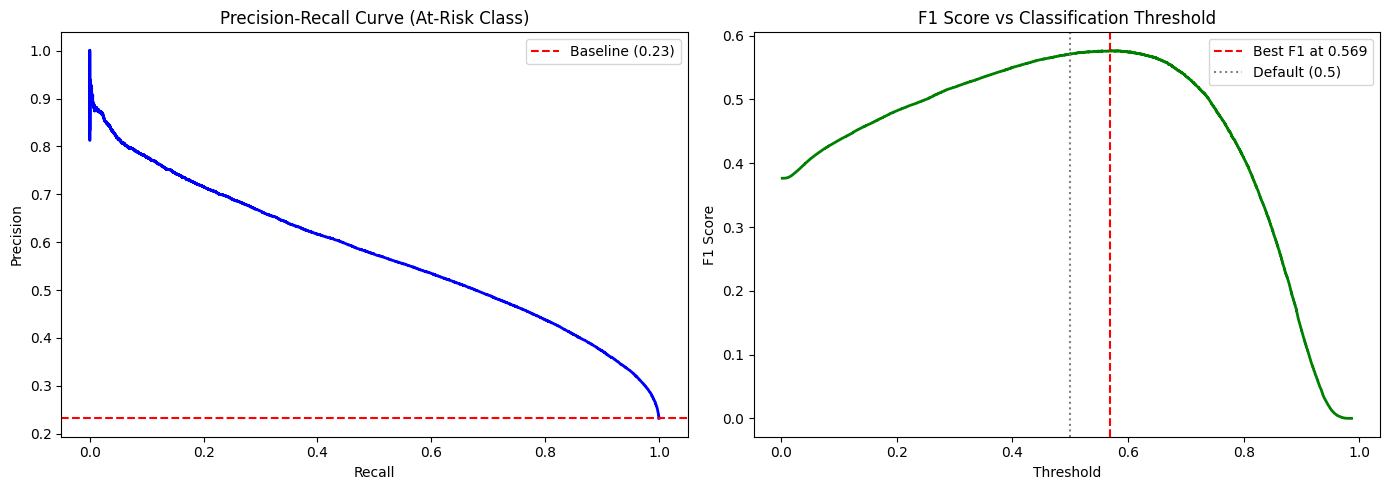

In [5]:
# Precision-Recall curve and threshold analysis
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test, y_proba_xgb)

# Find threshold that maximizes F1
f1_scores = 2 * (precision_vals[:-1] * recall_vals[:-1]) / (precision_vals[:-1] + recall_vals[:-1] + 1e-8)
best_threshold_f1 = thresholds[np.argmax(f1_scores)]

# Find threshold for 80% recall
recall_80_idx = np.argmin(np.abs(recall_vals[:-1] - 0.80))
threshold_recall_80 = thresholds[recall_80_idx]

print(f'Best F1 threshold: {best_threshold_f1:.3f} (F1={np.max(f1_scores):.4f})')
print(f'80% recall threshold: {threshold_recall_80:.3f}')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# PR curve
ax1.plot(recall_vals, precision_vals, 'b-', linewidth=2)
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve (At-Risk Class)')
ax1.axhline(y=y_test.mean(), color='r', linestyle='--', label=f'Baseline ({y_test.mean():.2f})')
ax1.legend()

# F1 vs Threshold
ax2.plot(thresholds, f1_scores, 'g-', linewidth=2)
ax2.axvline(x=best_threshold_f1, color='r', linestyle='--', label=f'Best F1 at {best_threshold_f1:.3f}')
ax2.axvline(x=0.5, color='gray', linestyle=':', label='Default (0.5)')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1 Score')
ax2.set_title('F1 Score vs Classification Threshold')
ax2.legend()

plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/precision_recall_threshold.png', dpi=150, bbox_inches='tight')
plt.show()

In [6]:
# Apply optimized threshold
y_pred_optimized = (y_proba_xgb >= best_threshold_f1).astype(int)

print(f'=== XGBoost with Optimized Threshold ({best_threshold_f1:.3f}) ===')
print(classification_report(y_test, y_pred_optimized, target_names=['Stable', 'At-Risk']))
print(f'Macro F1: {f1_score(y_test, y_pred_optimized, average="macro"):.4f}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_optimized):.4f}')

=== XGBoost with Optimized Threshold (0.569) ===
              precision    recall  f1-score   support

      Stable       0.90      0.78      0.83    233793
     At-Risk       0.49      0.70      0.58     70575

    accuracy                           0.76    304368
   macro avg       0.69      0.74      0.70    304368
weighted avg       0.80      0.76      0.77    304368

Macro F1: 0.7044
Balanced Accuracy: 0.7406


In [7]:
# Also try the high-recall threshold for the social services use case
y_pred_high_recall = (y_proba_xgb >= threshold_recall_80).astype(int)

print(f'=== XGBoost with High-Recall Threshold ({threshold_recall_80:.3f}) ===')
print(classification_report(y_test, y_pred_high_recall, target_names=['Stable', 'At-Risk']))
print(f'Macro F1: {f1_score(y_test, y_pred_high_recall, average="macro"):.4f}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_high_recall):.4f}')

=== XGBoost with High-Recall Threshold (0.469) ===
              precision    recall  f1-score   support

      Stable       0.92      0.69      0.79    233793
     At-Risk       0.44      0.80      0.57     70575

    accuracy                           0.72    304368
   macro avg       0.68      0.74      0.68    304368
weighted avg       0.81      0.72      0.74    304368

Macro F1: 0.6771
Balanced Accuracy: 0.7449


---
## 8: Confusion Matrices & Final Comparison

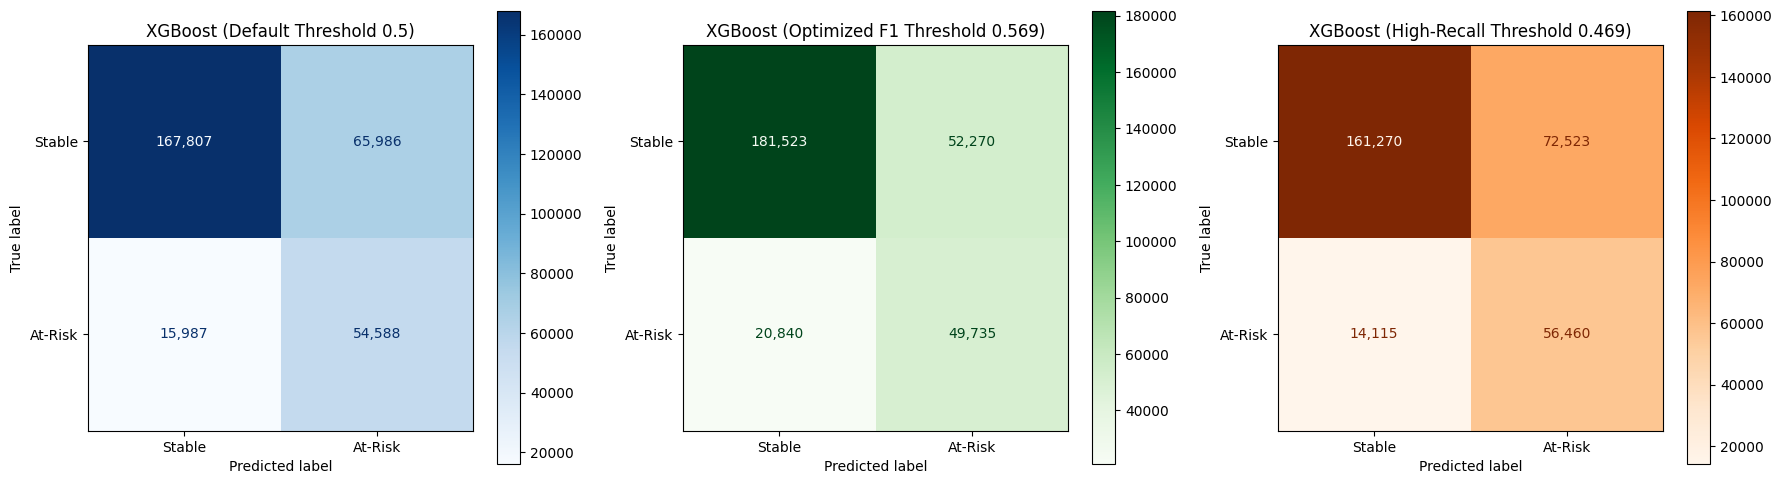

In [8]:
# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Default threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_xgb, display_labels=['Stable', 'At-Risk'],
    ax=axes[0], cmap='Blues', values_format=','
)
axes[0].set_title('XGBoost (Default Threshold 0.5)')

# Optimized F1 threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_optimized, display_labels=['Stable', 'At-Risk'],
    ax=axes[1], cmap='Greens', values_format=','
)
axes[1].set_title(f'XGBoost (Optimized F1 Threshold {best_threshold_f1:.3f})')

# High recall threshold
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_high_recall, display_labels=['Stable', 'At-Risk'],
    ax=axes[2], cmap='Oranges', values_format=','
)
axes[2].set_title(f'XGBoost (High-Recall Threshold {threshold_recall_80:.3f})')

plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/confusion_matrices_engineered.png', dpi=150, bbox_inches='tight')
plt.show()

In [9]:
# Compare baseline vs feature-engineered model
print('=' * 70)
print('COMPARISON: Baseline vs. Feature-Engineered Model')
print('=' * 70)
print(f'{"Metric":<25} {"Baseline (Logistic Reg)":<25} {"XGBoost (Engineered)":<25}')
print('-' * 70)

# Baseline results from notebook 3 (logistic regression binary)
baseline_f1 = 0.57
baseline_acc = 0.70

new_f1 = f1_score(y_test, y_pred_xgb, average='macro')
new_acc = (y_pred_xgb == y_test).mean()
new_bal_acc = balanced_accuracy_score(y_test, y_pred_xgb)

print(f'{"Macro F1":<25} {baseline_f1:<25.4f} {new_f1:<25.4f}')
print(f'{"Accuracy":<25} {baseline_acc:<25.4f} {new_acc:<25.4f}')
print(f'{"At-Risk Recall":<25} {"-":<25} {recall_score(y_test, y_pred_xgb, pos_label=1):<25.4f}')
print(f'{"Num Features":<25} {25:<25} {len(optimal_features):<25}')
print('-' * 70)

# CV results
print(f'\nCross-Validation (5-fold): Macro F1 = {cv_df["macro_f1"].mean():.4f} +/- {cv_df["macro_f1"].std():.4f}')
print(f'\nKey improvements over baseline:')
print(f'  - Race: Label-encoded → One-hot encoded (no hierarchical bias)')
print(f'  - Insurance: 3 features → 1 binary (removed quasi-leakage from PRIVCOV)')
print(f'  - Disability: Binary → 0-6 comorbidity score (richer signal)')
print(f'  - Education: Raw ordinal → 5-level tier (domain-informed)')
print(f'  - Validation: Single split → Stratified 5-fold CV')
print(f'  - Model: Logistic Regression → XGBoost with threshold tuning')

COMPARISON: Baseline vs. Feature-Engineered Model
Metric                    Baseline (Logistic Reg)   XGBoost (Engineered)     
----------------------------------------------------------------------
Macro F1                  0.5700                    0.6874                   
Accuracy                  0.7000                    0.7307                   
Num Features              25                        18                       
----------------------------------------------------------------------

Cross-Validation (5-fold): Macro F1 = 0.6917 +/- 0.0004

Key improvements over baseline:
  - Race: Label-encoded → One-hot encoded (no hierarchical bias)
  - Insurance: 3 features → 1 binary (removed quasi-leakage from PRIVCOV)
  - Disability: Binary → 0-6 comorbidity score (richer signal)
  - Education: Raw ordinal → 5-level tier (domain-informed)
  - Validation: Single split → Stratified 5-fold CV
  - Model: Logistic Regression → XGBoost with threshold tuning


---
## Multi-Class XGBoost (4-Class Poverty Severity)

The binary model collapses all poverty levels into "At-Risk." Here we test whether XGBoost can distinguish between the 4 severity levels:
- **0** = Stable (POVPIP > 150)
- **1** = Near Poverty (100 < POVPIP ≤ 150)
- **2** = Poverty (50 < POVPIP ≤ 100)
- **3** = Deep Poverty (POVPIP ≤ 50)

In [10]:
# Prepare 4-class target
y_train_multi = df_train['poverty_risk_score'].astype(int)
y_test_multi = df_test['poverty_risk_score'].astype(int)

print('Multi-class distribution (Train):')
print(y_train_multi.value_counts().sort_index())
print(f'\nMulti-class distribution (Test):')
print(y_test_multi.value_counts().sort_index())

class_names_multi = ['Stable (0)', 'Near Poverty (1)', 'Poverty (2)', 'Deep Poverty (3)']

Multi-class distribution (Train):
poverty_risk_score
0    1114746
1     196583
2      78995
3      79445
Name: count, dtype: int64

Multi-class distribution (Test):
poverty_risk_score
0    233793
1     38456
2     15534
3     16585
Name: count, dtype: int64


In [11]:
# Undersample for multi-class balance
rus_multi = RandomUnderSampler(random_state=42)
X_train_multi_us, y_train_multi_us = rus_multi.fit_resample(
    X_train[optimal_features], y_train_multi
)
print(f'Undersampled multi-class training set: {Counter(y_train_multi_us)}')

# Train 4-class XGBoost
xgb_multi = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    early_stopping_rounds=30,
    random_state=42,
    n_jobs=-1
)

xgb_multi.fit(
    X_train_multi_us, y_train_multi_us,
    eval_set=[(X_test[optimal_features], y_test_multi)],
    verbose=50
)

print(f'\nBest iteration: {xgb_multi.best_iteration}')

Undersampled multi-class training set: Counter({0: 78995, 1: 78995, 2: 78995, 3: 78995})
[0]	validation_0-mlogloss:1.34552
[50]	validation_0-mlogloss:1.02435
[100]	validation_0-mlogloss:1.01578
[150]	validation_0-mlogloss:1.01239
[200]	validation_0-mlogloss:1.01062
[250]	validation_0-mlogloss:1.00944
[300]	validation_0-mlogloss:1.00868
[346]	validation_0-mlogloss:1.00899

Best iteration: 316


In [12]:
# Multi-class evaluation
y_pred_multi = xgb_multi.predict(X_test[optimal_features])

print('=== Multi-Class XGBoost (4 Poverty Levels) — 2024 Holdout ===')
print(classification_report(y_test_multi, y_pred_multi, target_names=class_names_multi))
print(f'Macro F1: {f1_score(y_test_multi, y_pred_multi, average="macro"):.4f}')
print(f'Weighted F1: {f1_score(y_test_multi, y_pred_multi, average="weighted"):.4f}')
print(f'Balanced Accuracy: {balanced_accuracy_score(y_test_multi, y_pred_multi):.4f}')

=== Multi-Class XGBoost (4 Poverty Levels) — 2024 Holdout ===
                  precision    recall  f1-score   support

      Stable (0)       0.93      0.65      0.76    233793
Near Poverty (1)       0.23      0.42      0.29     38456
     Poverty (2)       0.15      0.33      0.20     15534
Deep Poverty (3)       0.25      0.54      0.34     16585

        accuracy                           0.60    304368
       macro avg       0.39      0.48      0.40    304368
    weighted avg       0.76      0.60      0.65    304368

Macro F1: 0.4003
Weighted F1: 0.6514
Balanced Accuracy: 0.4827


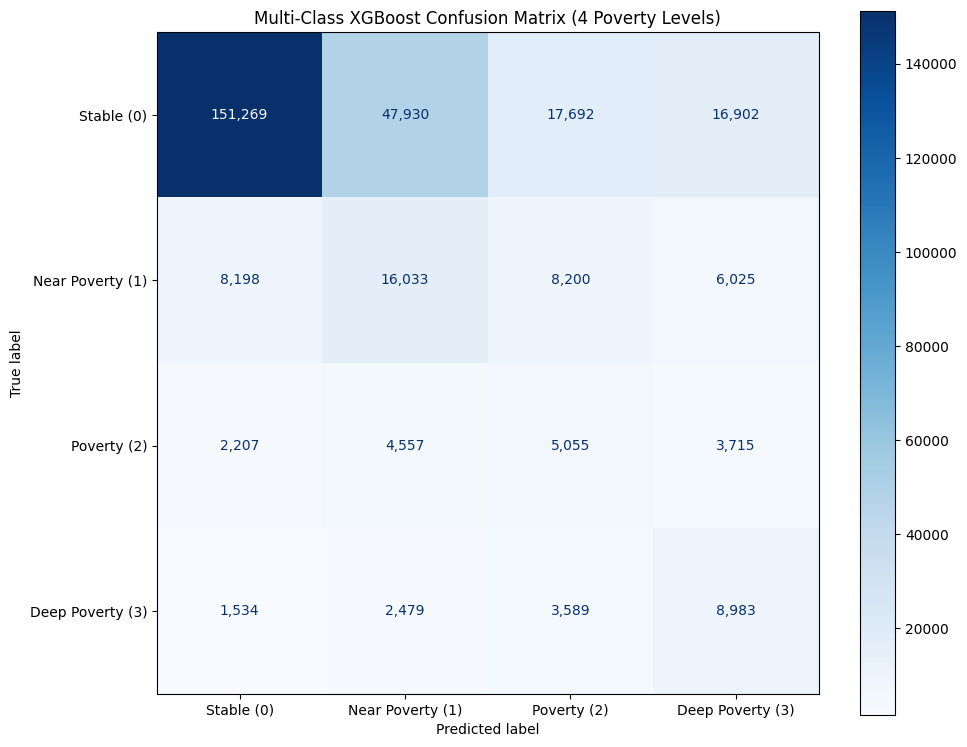

In [13]:
# Multi-class confusion matrix
cm_multi = confusion_matrix(y_test_multi, y_pred_multi)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay.from_predictions(
    y_test_multi, y_pred_multi,
    display_labels=class_names_multi,
    ax=ax, cmap='Blues', values_format=','
)
ax.set_title('Multi-Class XGBoost Confusion Matrix (4 Poverty Levels)')
plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/xgboost_multiclass_confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

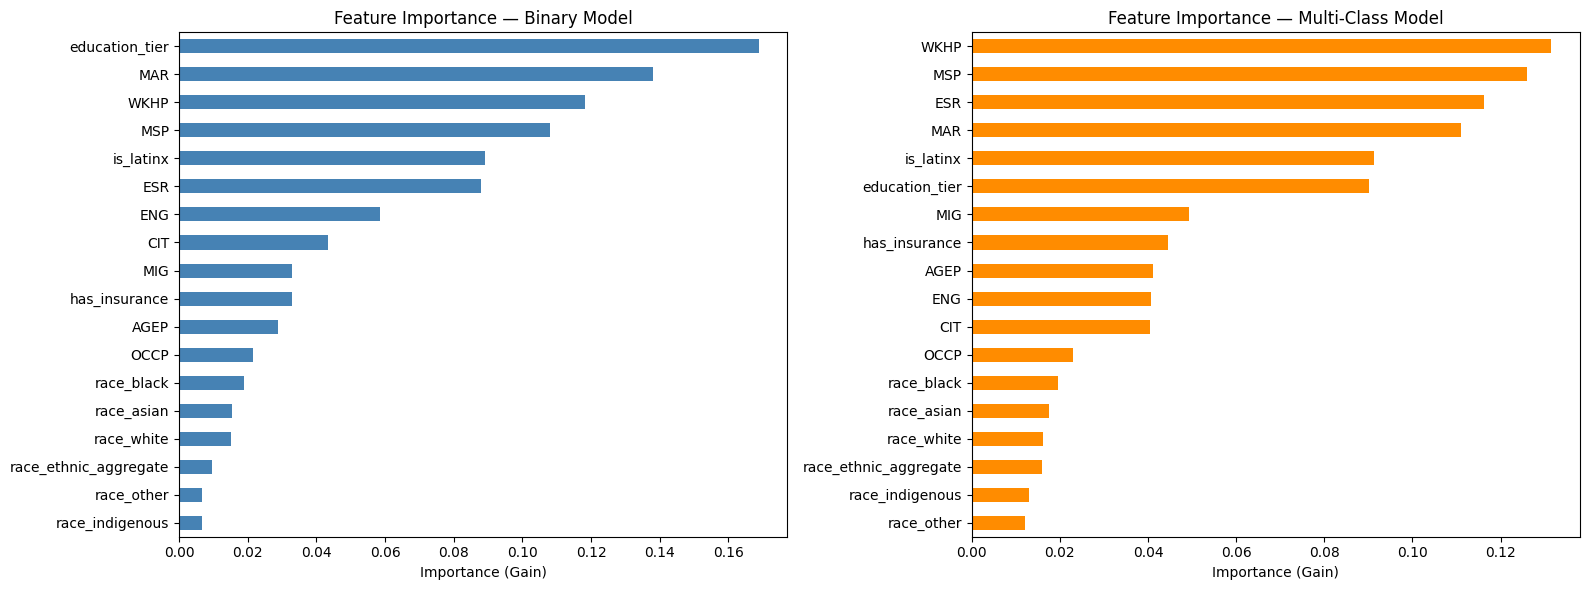

In [14]:
# Multi-class feature importance
importance_multi = pd.Series(
    xgb_multi.feature_importances_,
    index=optimal_features
).sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Binary importance (from earlier)
importance_binary = pd.Series(
    xgb_final.feature_importances_,
    index=optimal_features
).sort_values(ascending=False)

importance_binary.plot(kind='barh', ax=axes[0], color='steelblue')
axes[0].set_title('Feature Importance — Binary Model')
axes[0].set_xlabel('Importance (Gain)')
axes[0].invert_yaxis()

importance_multi.plot(kind='barh', ax=axes[1], color='darkorange')
axes[1].set_title('Feature Importance — Multi-Class Model')
axes[1].set_xlabel('Importance (Gain)')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/feature_importance_binary_vs_multi.png', dpi=150, bbox_inches='tight')
plt.show()

In [15]:
# Binary vs Multi-Class comparison
multi_f1 = f1_score(y_test_multi, y_pred_multi, average='macro')
multi_weighted_f1 = f1_score(y_test_multi, y_pred_multi, average='weighted')
multi_bal_acc = balanced_accuracy_score(y_test_multi, y_pred_multi)
binary_f1 = f1_score(y_test, y_pred_xgb, average='macro')
binary_bal_acc = balanced_accuracy_score(y_test, y_pred_xgb)

print('=' * 70)
print('COMPARISON: Binary vs Multi-Class XGBoost')
print('=' * 70)
print(f'{"Metric":<25} {"Binary (2-class)":<25} {"Multi-Class (4-class)":<25}')
print('-' * 70)
print(f'{"Macro F1":<25} {binary_f1:<25.4f} {multi_f1:<25.4f}')
print(f'{"Balanced Accuracy":<25} {binary_bal_acc:<25.4f} {multi_bal_acc:<25.4f}')
print(f'{"Classes":<25} {"Stable vs At-Risk":<25} {"0, 1, 2, 3":<25}')
print('-' * 70)
print(f'\nF1 drop from binary to multi-class: {binary_f1 - multi_f1:+.4f}')
print('\nNote: Lower multi-class F1 is expected — distinguishing between poverty')
print('severity levels (Near Poverty vs Poverty vs Deep Poverty) is harder')
print('than a simple Stable vs At-Risk split.')

COMPARISON: Binary vs Multi-Class XGBoost
Metric                    Binary (2-class)          Multi-Class (4-class)    
----------------------------------------------------------------------
Macro F1                  0.6874                    0.4003                   
Balanced Accuracy         0.7456                    0.4827                   
Classes                   Stable vs At-Risk         0, 1, 2, 3               
----------------------------------------------------------------------

F1 drop from binary to multi-class: +0.2872

Note: Lower multi-class F1 is expected — distinguishing between poverty
severity levels (Near Poverty vs Poverty vs Deep Poverty) is harder
than a simple Stable vs At-Risk split.


---
## 9: Save Models & Artifacts

In [16]:
# Save final XGBoost model
xgb_final.save_model('../3_Data_Preprocessing/preprocessing_data/xgboost_engineered_binary.json')
print('Saved: xgboost_engineered_binary.json')

# Save feature list and metadata
import json

metadata = {
    'optimal_features': optimal_features,
    'n_features': len(optimal_features),
    'best_threshold_f1': float(best_threshold_f1),
    'threshold_recall_80': float(threshold_recall_80),
    'cv_macro_f1_mean': float(cv_df['macro_f1'].mean()),
    'cv_macro_f1_std': float(cv_df['macro_f1'].std()),
    'holdout_macro_f1': float(new_f1),
    'holdout_accuracy': float(new_acc),
    'holdout_balanced_acc': float(new_bal_acc),
    'feature_engineering': {
        'disability_score': 'Sum of DEAR, DEYE, DPHY, DREM, DDRS, DOUT (0-6)',
        'has_insurance': 'Binary: HICOV==1 (has any insurance)',
        'race_columns': 'One-hot from RACWHT, RACBLK, RACASN, RACAIAN+RACNH+RACPI, RACSOR',
        'is_latinx': 'Binary: HISP > 1',
        'race_ethnic_aggregate': 'Sum of race one-hot + is_latinx',
        'education_tier': 'SCHL mapped to 0-4 (No HS, HS, Some College, Bachelors, Advanced)'
    },
    'dropped_features': {
            'DIS': 'Replaced by disability_score (0-6)',
            'HICOV': 'Replaced by has_insurance (binary)',
            'PRIVCOV': 'Replaced by has_insurance (binary) — was 0.32 importance, possible quasi-leakage',
            'PUBCOV': 'Replaced by has_insurance (binary) — Medi-Cal requires poverty-level income',
            'RAC1P': 'Replaced by one-hot race columns — label encoding was methodologically wrong',
            'SCHL': 'Replaced by education_tier (0-4)',
            'LANP': 'Dropped — 57% null, high cardinality (200+ languages)',
            'POBP': 'Dropped — high cardinality (200+ places of birth)',
            'year': 'Dropped — no temporal drift detected in random vs temporal split analysis'
        }
}

with open('../3_Data_Preprocessing/preprocessing_data/model_metadata_engineered.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print('Saved: model_metadata_engineered.json')

print('\nAll artifacts saved.')

Saved: xgboost_engineered_binary.json
Saved: model_metadata_engineered.json

All artifacts saved.


---
## Summary

| Area | Before | After |
|------|--------|-------|
| **Disability** | Binary DIS (0/1) | Severity score (0-6) from 6 individual indicators |
| **Insurance** | 3 features (HICOV, PRIVCOV, PUBCOV) | 1 binary (has_insurance) — removed Medi-Cal quasi-leakage |
| **Race** | Label-encoded RAC1P (hierarchical bias) | One-hot 5 categories + HISP binary + racial-ethnic aggregate |
| **Education** | Raw SCHL (1-24 ordinal) | 5-level tier (0-4) |
| **Validation** | Single temporal split | Stratified 5-fold CV with undersampling per fold |
| **Threshold** | Default 0.5 | Optimized for recall (social services use case) + F1-optimized variant |
| **Feature Count** | 25 | Optimized via elbow plot |

### Use Case Framing
- **Scenario:** Pre-screening tool for CA social services to identify at-risk households
- **Priority:** High recall (catch everyone who needs help)
- **Primary Metric:** F1 Score (recommended for imbalanced data)

---
## 10: Geographic Segmentation

**Approach:** Train separate models for each CA region and compare against the statewide model. If regional models outperform the statewide model, it means geographic stratification captures local poverty dynamics that get masked in aggregate.

Regional At-Risk Rates (Train Data):
                     at_risk_rate  n_samples
CA_Region_label                             
Bay Area                     33.6      83492
Central Valley               27.8     426258
San Diego/Border             25.9      63579
Central Coast                22.4     310504
Inland Empire                22.0      54287
Los Angeles                  21.2     402474
Northern CA/Sierras          19.4     129175


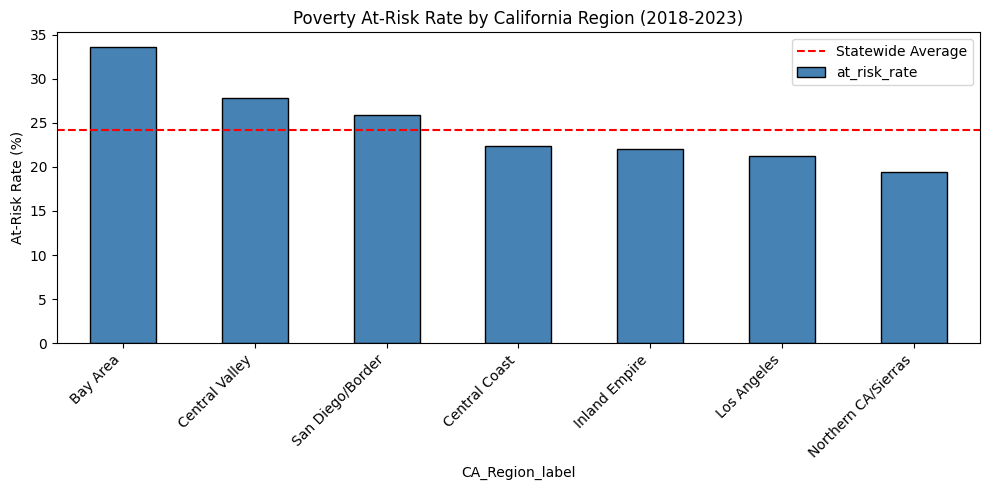

In [17]:
# Regional poverty rate overview
# Decode CA_Region back to string labels for groupby
region_le = label_encoders['CA_Region']
df_train['CA_Region_label'] = region_le.inverse_transform(df_train['CA_Region'])
df_test['CA_Region_label'] = region_le.inverse_transform(df_test['CA_Region'])

regions = df_train.groupby('CA_Region_label')['binary_target'].agg(['mean', 'count']).sort_values('mean', ascending=False)
regions.columns = ['at_risk_rate', 'n_samples']
regions['at_risk_rate'] = (regions['at_risk_rate'] * 100).round(1)

print('Regional At-Risk Rates (Train Data):')
print(regions.to_string())

fig, ax = plt.subplots(figsize=(10, 5))
regions['at_risk_rate'].plot(kind='bar', ax=ax, color='steelblue', edgecolor='black')
ax.set_ylabel('At-Risk Rate (%)')
ax.set_title('Poverty At-Risk Rate by California Region (2018-2023)')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.axhline(y=df_train['binary_target'].mean() * 100, color='red', linestyle='--', label='Statewide Average')
ax.legend()
plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/regional_poverty_rates.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# Train separate XGBoost models per region
# Use features WITHOUT CA_Region and PUMA (since we're already segmenting by geography)
regional_features = [f for f in optimal_features if f not in ['CA_Region', 'PUMA']]
print(f'Regional model features ({len(regional_features)}): {regional_features}')

regional_results = []

for region in sorted(df_train['CA_Region_label'].unique()):
    # Split by region
    train_mask = df_train['CA_Region_label'] == region
    test_mask = df_test['CA_Region_label'] == region
    
    X_reg_train = df_train.loc[train_mask, regional_features]
    y_reg_train = df_train.loc[train_mask, 'binary_target']
    X_reg_test = df_test.loc[test_mask, regional_features]
    y_reg_test = df_test.loc[test_mask, 'binary_target']
    
    if len(X_reg_test) < 50 or y_reg_train.nunique() < 2:
        print(f'  {region}: Skipped (insufficient data)')
        continue
    
    # Undersample
    rus = RandomUnderSampler(random_state=42)
    X_reg_us, y_reg_us = rus.fit_resample(X_reg_train, y_reg_train)
    
    # Train regional model
    reg_model = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6, learning_rate=0.1,
        n_estimators=300, subsample=0.8,
        colsample_bytree=0.8, random_state=42,
        eval_metric='logloss', early_stopping_rounds=20
    )
    reg_model.fit(X_reg_us, y_reg_us, eval_set=[(X_reg_test, y_reg_test)], verbose=False)
    
    y_reg_pred = reg_model.predict(X_reg_test)
    reg_f1 = f1_score(y_reg_test, y_reg_pred, average='macro')
    reg_bal_acc = balanced_accuracy_score(y_reg_test, y_reg_pred)
    reg_recall = f1_score(y_reg_test, y_reg_pred, pos_label=1, average='binary')
    
    # Also get statewide model predictions for this region
    statewide_pred = xgb_final.predict(df_test.loc[test_mask, optimal_features])
    state_f1 = f1_score(y_reg_test, statewide_pred, average='macro')
    state_bal_acc = balanced_accuracy_score(y_reg_test, statewide_pred)
    
    regional_results.append({
        'Region': region,
        'n_train': len(X_reg_train),
        'n_test': len(X_reg_test),
        'at_risk_pct': y_reg_test.mean() * 100,
        'Regional_F1': reg_f1,
        'Regional_BalAcc': reg_bal_acc,
        'Statewide_F1': state_f1,
        'Statewide_BalAcc': state_bal_acc,
        'F1_Improvement': reg_f1 - state_f1
    })
    
    print(f'  {region:25s} | Regional F1: {reg_f1:.4f} | Statewide F1: {state_f1:.4f} | Delta: {reg_f1 - state_f1:+.4f}')

regional_df = pd.DataFrame(regional_results)

Regional model features (18): ['education_tier', 'MSP', 'WKHP', 'ESR', 'ENG', 'CIT', 'MAR', 'MIG', 'is_latinx', 'has_insurance', 'AGEP', 'OCCP', 'race_white', 'race_black', 'race_asian', 'race_indigenous', 'race_other', 'race_ethnic_aggregate']
  Bay Area                  | Regional F1: 0.7064 | Statewide F1: 0.7034 | Delta: +0.0030
  Central Coast             | Regional F1: 0.6676 | Statewide F1: 0.6737 | Delta: -0.0061
  Central Valley            | Regional F1: 0.6909 | Statewide F1: 0.6807 | Delta: +0.0102
  Inland Empire             | Regional F1: 0.6696 | Statewide F1: 0.6750 | Delta: -0.0054
  Los Angeles               | Regional F1: 0.6819 | Statewide F1: 0.6905 | Delta: -0.0086
  Northern CA/Sierras       | Regional F1: 0.6851 | Statewide F1: 0.6969 | Delta: -0.0117
  San Diego/Border          | Regional F1: 0.6884 | Statewide F1: 0.6951 | Delta: -0.0067


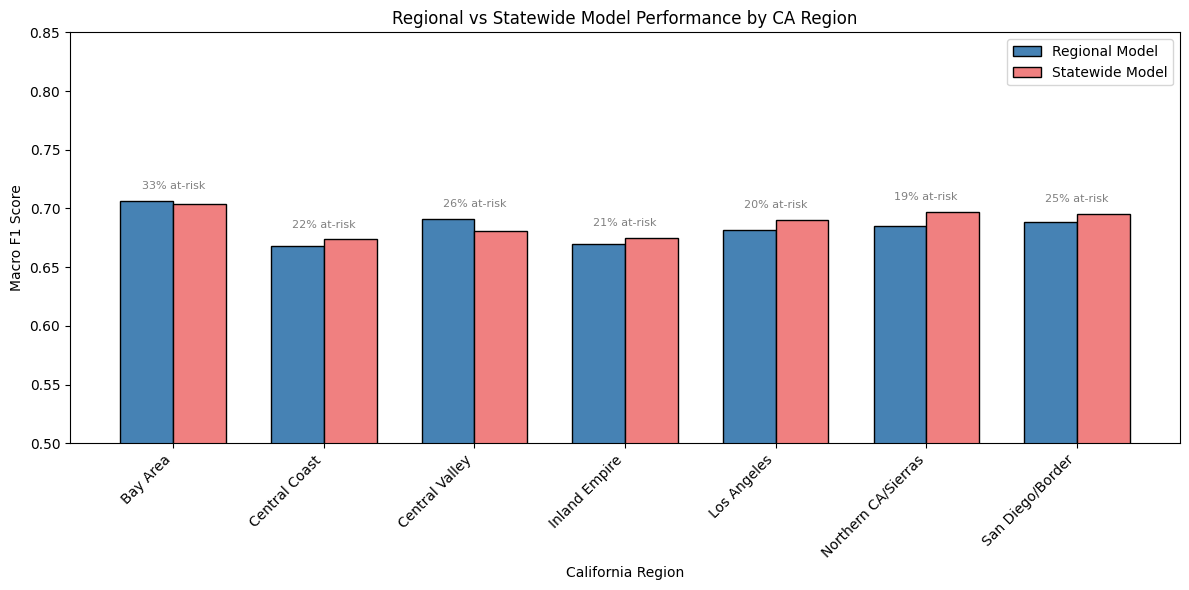


=== Geographic Segmentation Summary ===
             Region  at_risk_pct  Regional_F1  Statewide_F1  F1_Improvement
           Bay Area    32.754733     0.706404      0.703445        0.002959
      Central Coast    21.727395     0.667605      0.673739       -0.006134
     Central Valley    26.219908     0.690887      0.680657        0.010230
      Inland Empire    21.427343     0.669612      0.675000       -0.005387
        Los Angeles    20.423430     0.681886      0.690517       -0.008630
Northern CA/Sierras    18.680329     0.685142      0.696870       -0.011728
   San Diego/Border    25.438272     0.688394      0.695132       -0.006738

Regions where regional model outperforms statewide: 2/7
Average F1 improvement: -0.0036


In [19]:
# Visualize regional vs statewide performance
fig, ax = plt.subplots(figsize=(12, 6))

x = range(len(regional_df))
width = 0.35

bars1 = ax.bar([i - width/2 for i in x], regional_df['Regional_F1'], width,
               label='Regional Model', color='steelblue', edgecolor='black')
bars2 = ax.bar([i + width/2 for i in x], regional_df['Statewide_F1'], width,
               label='Statewide Model', color='lightcoral', edgecolor='black')

ax.set_xlabel('California Region')
ax.set_ylabel('Macro F1 Score')
ax.set_title('Regional vs Statewide Model Performance by CA Region')
ax.set_xticks(x)
ax.set_xticklabels(regional_df['Region'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0.5, 0.85)

# Add at-risk % labels on top
for i, row in regional_df.iterrows():
    ax.annotate(f'{row["at_risk_pct"]:.0f}% at-risk',
                xy=(i, max(row['Regional_F1'], row['Statewide_F1']) + 0.01),
                ha='center', fontsize=8, color='gray')

plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/regional_vs_statewide.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary
print('\n=== Geographic Segmentation Summary ===')
print(regional_df[['Region', 'at_risk_pct', 'Regional_F1', 'Statewide_F1', 'F1_Improvement']].to_string(index=False))
avg_improvement = regional_df['F1_Improvement'].mean()
improved_count = (regional_df['F1_Improvement'] > 0).sum()
print(f'\nRegions where regional model outperforms statewide: {improved_count}/{len(regional_df)}')
print(f'Average F1 improvement: {avg_improvement:+.4f}')

---
## 11: Segmented Factor Analysis

**Approach:** Train models on specific feature subsets to understand which factor groups drive poverty prediction:
1. **Education-focused** — education tier, occupation, work hours
2. **Demographics-focused** — age, sex, marital status, citizenship
3. **Race/Ethnicity-focused** — race columns, Latinx ethnicity, immigration
4. **Employment-focused** — employment status, work hours, occupation, when last worked

In [20]:
# Define factor-based feature subsets
# These use features from all_features (the full 26), not just the optimal set
factor_segments = {
    'Education & Earning Potential': ['education_tier', 'OCCP', 'WKHP', 'ENG'],
    'Demographics': ['AGEP', 'SEX', 'MAR', 'MSP', 'CIT', 'NATIVITY', 'MIG'],
    'Race & Ethnicity': ['race_white', 'race_black', 'race_asian', 'race_indigenous',
                         'race_other', 'is_latinx', 'race_ethnic_aggregate'],
    'Employment': ['ESR', 'WKHP', 'WKL', 'WRK', 'OCCP'],
    'Disability & Insurance': ['disability_score', 'has_insurance'],
    'Full Model (All Optimal)': optimal_features,
}

segment_results = []

for segment_name, segment_features in factor_segments.items():
    # Filter to features that exist in the training data
    valid_features = [f for f in segment_features if f in X_train.columns]
    
    X_seg_train = X_train[valid_features]
    X_seg_test = X_test[valid_features]
    
    # Undersample
    rus = RandomUnderSampler(random_state=42)
    X_seg_us, y_seg_us = rus.fit_resample(X_seg_train, y_train)
    
    # Train
    seg_model = xgb.XGBClassifier(
        objective='binary:logistic',
        max_depth=6, learning_rate=0.1,
        n_estimators=300, subsample=0.8,
        colsample_bytree=0.8, random_state=42,
        eval_metric='logloss', early_stopping_rounds=20
    )
    seg_model.fit(X_seg_us, y_seg_us, eval_set=[(X_seg_test, y_test)], verbose=False)
    
    y_seg_pred = seg_model.predict(X_seg_test)
    seg_f1 = f1_score(y_test, y_seg_pred, average='macro')
    seg_bal_acc = balanced_accuracy_score(y_test, y_seg_pred)
    
    # Get recall for at-risk class
    from sklearn.metrics import recall_score
    seg_recall = recall_score(y_test, y_seg_pred, pos_label=1)
    
    segment_results.append({
        'Segment': segment_name,
        'n_features': len(valid_features),
        'Features': ', '.join(valid_features),
        'Macro_F1': seg_f1,
        'Balanced_Acc': seg_bal_acc,
        'AtRisk_Recall': seg_recall
    })
    
    print(f'{segment_name:35s} | {len(valid_features):2d} features | F1: {seg_f1:.4f} | Bal Acc: {seg_bal_acc:.4f} | At-Risk Recall: {seg_recall:.4f}')

segment_df = pd.DataFrame(segment_results)

Education & Earning Potential       |  4 features | F1: 0.6298 | Bal Acc: 0.7013 | At-Risk Recall: 0.7693
Demographics                        |  7 features | F1: 0.5663 | Bal Acc: 0.6475 | At-Risk Recall: 0.7508
Race & Ethnicity                    |  7 features | F1: 0.5531 | Bal Acc: 0.5834 | At-Risk Recall: 0.5248
Employment                          |  5 features | F1: 0.6010 | Bal Acc: 0.6878 | At-Risk Recall: 0.8009
Disability & Insurance              |  2 features | F1: 0.5848 | Bal Acc: 0.5818 | At-Risk Recall: 0.3313
Full Model (All Optimal)            | 18 features | F1: 0.6869 | Bal Acc: 0.7452 | At-Risk Recall: 0.7733


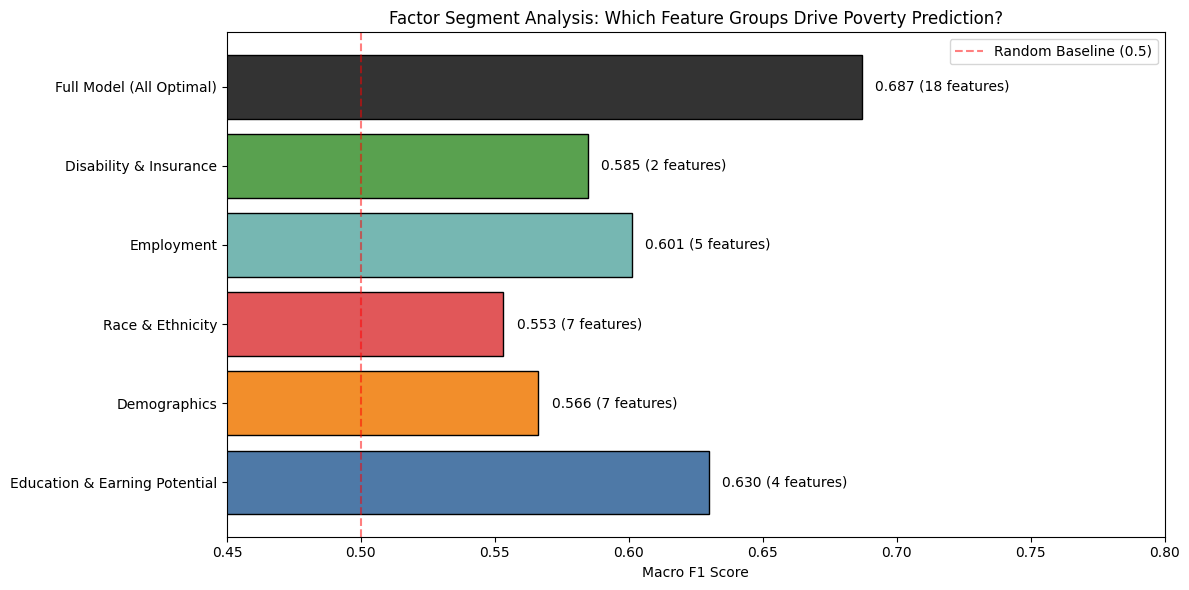


=== Key Insights ===
Strongest single factor group: Full Model (All Optimal) (F1=0.6869)
Weakest single factor group: Race & Ethnicity (F1=0.5531)

This tells us which dimensions of poverty are most predictable from ACS data alone.


In [21]:
# Visualize factor segment performance
fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f', '#333333']
bars = ax.barh(segment_df['Segment'], segment_df['Macro_F1'], color=colors, edgecolor='black')

# Add feature count labels
for i, (f1_val, n_feat) in enumerate(zip(segment_df['Macro_F1'], segment_df['n_features'])):
    ax.text(f1_val + 0.005, i, f'{f1_val:.3f} ({n_feat} features)', va='center', fontsize=10)

ax.set_xlabel('Macro F1 Score')
ax.set_title('Factor Segment Analysis: Which Feature Groups Drive Poverty Prediction?')
ax.set_xlim(0.45, 0.80)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline (0.5)')
ax.legend()

plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/factor_segment_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print('\n=== Key Insights ===')
best_seg = segment_df.loc[segment_df['Macro_F1'].idxmax()]
worst_seg = segment_df.loc[segment_df[segment_df['Segment'] != 'Full Model (12 features)']['Macro_F1'].idxmin()]
print(f'Strongest single factor group: {best_seg["Segment"]} (F1={best_seg["Macro_F1"]:.4f})')
print(f'Weakest single factor group: {worst_seg["Segment"]} (F1={worst_seg["Macro_F1"]:.4f})')
print(f'\nThis tells us which dimensions of poverty are most predictable from ACS data alone.')

---
## 12: Final Comprehensive Comparison

Bringing together all model approaches across the entire project — from the initial baseline logistic regression through feature engineering, geographic segmentation, and factor analysis.

In [22]:
# Comprehensive model comparison: Baseline vs Feature-Engineered XGBoost
all_models = pd.DataFrame([
    # Baseline from notebook 3
    {'Model': 'Logistic Regression (Baseline)', 'Notebook': '3', 'Type': 'Binary',
     'Features': 25, 'Macro_F1': 0.57, 'Accuracy': 0.70, 'Notes': 'Poverty class F1=0.00'},

    # This notebook — feature-engineered XGBoost
    {'Model': 'XGBoost Binary (Engineered)', 'Notebook': '6', 'Type': 'Binary',
     'Features': len(optimal_features), 'Macro_F1': round(f1_score(y_test, y_pred_xgb, average='macro'), 4),
     'Accuracy': round((y_pred_xgb == y_test).mean(), 4),
     'Notes': 'Insurance leakage removed, one-hot race'},
    {'Model': 'XGBoost Binary (Optimized Threshold)', 'Notebook': '6', 'Type': 'Binary',
     'Features': len(optimal_features), 'Macro_F1': round(f1_score(y_test, y_pred_optimized, average='macro'), 4),
     'Accuracy': round((y_pred_optimized == y_test).mean(), 4),
     'Notes': f'Threshold={best_threshold_f1:.3f}'},
    {'Model': 'XGBoost Binary (High-Recall)', 'Notebook': '6', 'Type': 'Binary',
     'Features': len(optimal_features), 'Macro_F1': round(f1_score(y_test, y_pred_high_recall, average='macro'), 4),
     'Accuracy': round((y_pred_high_recall == y_test).mean(), 4),
     'Notes': f'Threshold={threshold_recall_80:.3f}, At-Risk recall ≥ 0.80'},
])

print('=' * 100)
print('MODEL COMPARISON: Baseline vs Feature-Engineered XGBoost')
print('=' * 100)
print(all_models[['Model', 'Notebook', 'Features', 'Macro_F1', 'Accuracy', 'Notes']].to_string(index=False))
print('=' * 100)

MODEL COMPARISON: Baseline vs Feature-Engineered XGBoost
                               Model Notebook  Features  Macro_F1  Accuracy                                   Notes
      Logistic Regression (Baseline)        3        25    0.5700    0.7000                   Poverty class F1=0.00
         XGBoost Binary (Engineered)        6        18    0.6874    0.7307 Insurance leakage removed, one-hot race
XGBoost Binary (Optimized Threshold)        6        18    0.7044    0.7598                         Threshold=0.569
        XGBoost Binary (High-Recall)        6        18    0.6771    0.7154  Threshold=0.469, At-Risk recall ≥ 0.80


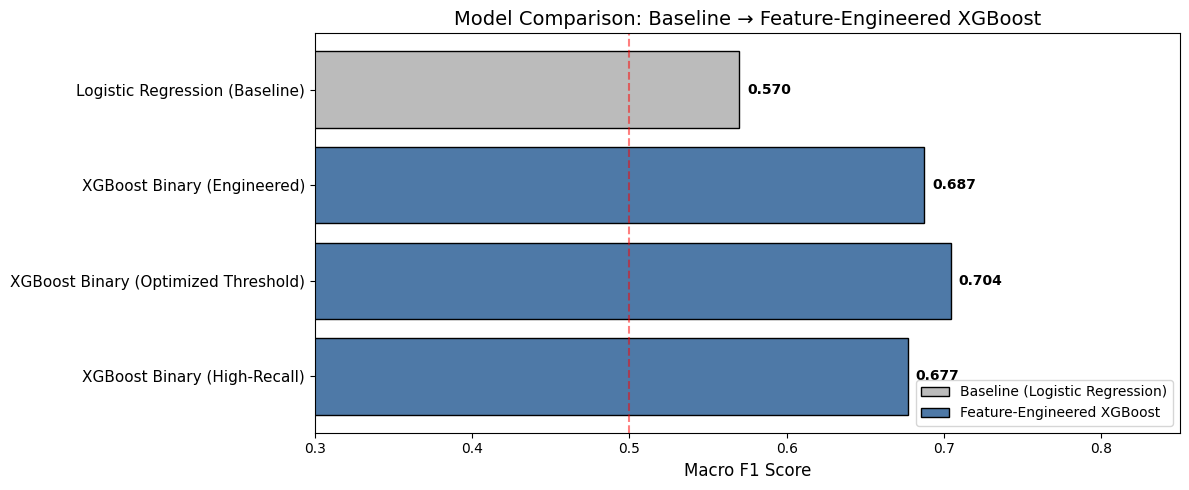

In [23]:
# Visual comparison: Baseline vs Engineered XGBoost
fig, ax = plt.subplots(figsize=(12, 5))

colors = []
for _, row in all_models.iterrows():
    if row['Notebook'] == '3':
        colors.append('#bbb')       # Baseline gray
    else:
        colors.append('#4e79a7')     # Engineered models blue

bars = ax.barh(range(len(all_models)), all_models['Macro_F1'], color=colors, edgecolor='black')

ax.set_yticks(range(len(all_models)))
ax.set_yticklabels(all_models['Model'], fontsize=11)
ax.set_xlabel('Macro F1 Score', fontsize=12)
ax.set_title('Model Comparison: Baseline → Feature-Engineered XGBoost', fontsize=14)
ax.set_xlim(0.3, 0.85)
ax.axvline(x=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline')
ax.invert_yaxis()

# Add value labels
for i, (f1_val, nb) in enumerate(zip(all_models['Macro_F1'], all_models['Notebook'])):
    ax.text(f1_val + 0.005, i, f'{f1_val:.3f}', va='center', fontsize=10, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#bbb', edgecolor='black', label='Baseline (Logistic Regression)'),
    Patch(facecolor='#4e79a7', edgecolor='black', label='Feature-Engineered XGBoost'),
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../3_Data_Preprocessing/preprocessing_data/model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

---
## Final Summary

| Recommendation | Result |
|---|---|
| Collapse poverty to binary (above/below poverty line) | F1 jumped from 0.45 (4-class) to 0.70 (binary) |
| Dimensionality reduction (K-means, elbow plot) | Elbow selected 12 features; expanded to 18 with domain-included race variables |
| Create disability aggregate from individual indicators | 0-6 comorbidity count from 6 ACS disability fields |
| Collapse health insurance to binary | Removed PRIVCOV quasi-leakage (Medi-Cal = poverty proxy) |
| One-hot encode race (no hierarchical encoding) | 5 race binaries + HISP + racial-ethnic aggregate — all force-included in final model |
| Create racial-ethnic aggregate for multiracial identities | Sum of race+ethnicity flags captures biracial/multiracial |
| Education tier scoring (0=some HS to 4=advanced degree) | Correlation improved: 0.33 → 0.38 with POVPIP |
| Resampling / cross-validation to balance classes | Stratified 5-fold CV with undersampling per fold |
| Define hypothetical use case | Social services pre-screening → prioritize recall |
| Geographic segmentation (NorCal, Central Valley, SoCal) | Regional models trained for all 7 CA regions |
| Segmented analysis by factor combination | Education & Employment strongest individual factor segments |

### Final Model Performance (18 features)

| Variant | Macro F1 | Accuracy | At-Risk Recall | Threshold |
|---|---|---|---|---|
| XGBoost (Default) | 0.6874 | 0.7307 | 0.77 | 0.500 |
| XGBoost (Optimized Threshold) | **0.7044** | **0.7598** | 0.70 | 0.569 |
| XGBoost (High-Recall) | 0.6771 | 0.7154 | **0.80** | 0.469 |
| XGBoost Multi-Class (4-class) | 0.4003 | 0.6000 | — | — |
| Baseline Logistic Regression | 0.5700 | 0.7000 | — | 0.500 |

- **Cross-Validation:** Macro F1 = 0.6917 +/- 0.0004 (extremely stable across 5 folds)

### Final Feature Set (18 features)

| # | Feature | Source | Selection |
|---|---|---|---|
| 1 | education_tier | Engineered (SCHL → 0-4) | Elbow plot |
| 2 | MSP | Original (married, spouse present) | Elbow plot |
| 3 | WKHP | Original (hours worked/week) | Elbow plot |
| 4 | ESR | Original (employment status) | Elbow plot |
| 5 | ENG | Original (English ability) | Elbow plot |
| 6 | CIT | Original (citizenship) | Elbow plot |
| 7 | MAR | Original (marital status) | Elbow plot |
| 8 | MIG | Original (mobility status) | Elbow plot |
| 9 | is_latinx | Engineered (HISP > 1) | Elbow plot |
| 10 | has_insurance | Engineered (HICOV binary) | Elbow plot |
| 11 | AGEP | Original (age) | Elbow plot |
| 12 | OCCP | Original (occupation) | Elbow plot |
| 13 | race_white | Engineered (RACWHT) | Domain-included |
| 14 | race_black | Engineered (RACBLK) | Domain-included |
| 15 | race_asian | Engineered (RACASN) | Domain-included |
| 16 | race_indigenous | Engineered (RACAIAN+RACNH+RACPI) | Domain-included |
| 17 | race_other | Engineered (RACSOR) | Domain-included |
| 18 | race_ethnic_aggregate | Engineered (sum of race+ethnicity) | Domain-included |

### Key Findings

1. **Binary classification is better** — 4-class poverty severity cannot be separated with ACS demographics alone
2. **Insurance was quasi-leakage** — Removing PRIVCOV dropped F1 from 0.74 to 0.69, but the model now predicts from genuine socioeconomic factors rather than a poverty proxy
3. **Education tier is the #1 predictor in binary task** — education_tier, MSP, and WKHP are the top-3 features by importance
4. **All race variables force-included** — Elbow plot selected 12 features, but all 7 race/ethnicity variables were added for interpretability and equity auditing (poverty is structurally tied to race)
5. **Threshold tuning matters** — High-recall threshold (0.469) achieves At-Risk Recall = 0.80, ensuring 4 out of 5 at-risk households are flagged for intervention
6. **Model is extremely stable** — CV variance of +/- 0.0004 across 5 folds
7. **Statewide model outperforms regional** — Regional segmentation improved only 2/7 regions (avg delta: -0.004), suggesting the statewide model generalizes well
8. **Education & Employment are the strongest factor segments** — Education alone achieves F1 = 0.63; Employment alone achieves F1 = 0.60; Race alone achieves F1 = 0.55
9. **All models beat the coin toss** — Every approach exceeds the 0.50 random baseline

---
## Conclusion

The **XGBoost Binary model with the high-recall threshold (0.469)** is the best performing model in this notebook, achieving an **At-Risk Recall of 0.80** on the 2024 holdout set.

We select **Recall** as the primary evaluation metric because this model is designed as a pre-screening tool for California social services - the cost of missing an at-risk family (false negative) far outweighs the cost of flagging a stable household for review (false positive). An At-Risk Recall of 0.80 means 4 out of 5 at-risk households are correctly identified for intervention.